## Data Cleaning & Dataframe Prep

This notebook handles the following tasks and prepares the data for the analysis.
If you something off, please fix it and add it to here.

Data Cleaning

- Delete NaN entries.
- Assign 0: Not Applicable to the Empirical Novelty that has been chosen as "Not Applicaple". We have observed that this occurs when reviewers think empirical novelty is not applicaple to a paper, which can be a theoretical one for instance. When calculating the mean of this, please do not include 0 entries.
- Ethics Flags include data which says both NO. and Yes, ... All of the contradictory entries included explanations, so we have accepted them as Yes.
- Delete reviews submitted after the deadline

Data Preparation

- Statistics related to each reviewer is calculated for each paper.
- These statics are: std, mean, diff(max_score-min_score)

### Resulting datasets

- review_df_clean -> reviewer per row cleaned data
- paper_df -> per paper dataframe, statistics are calculated such as mean, std, variance, max_min difference etc.
- df -> basic dataset

In [1]:
import pandas as pd 
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt

file_name = "../data/ICLR.cc-2023-Conference.csv"
df = pd.read_csv(file_name)

In [2]:
df.columns = df.columns.str.replace("recommendation", "score", regex=False)

### Dataframe 1: Reviewers as rows

In [3]:
# Instead of one row per paper, arrange data to have one reviewer per row.

reviewer_feature_cols = [col.split('reviewer1_')[1] for col in df.columns if col.startswith('reviewer1')]
for i in reviewer_feature_cols:
    print(i)
reviewer_cols = [col for col in df.columns for i in range(1, 5) if col.startswith('reviewer' + str(i) + '_')]
non_reviewer_cols = [col for col in df.columns if col not in reviewer_cols]


df['paper_no'] = np.arange(len(df))
review_df = pd.DataFrame(columns=['paper_id', 'reviewer', 'reviewer_score', 'reviewer_confidence', 'reviewer_summary_of_the_paper', 'reviewer_strength_and_weaknesses', 'reviewer_clarity_quality_novelty_and_reproducibility', 'reviewer_summary_of_the_review', 'reviewer_correctness', 'reviewer_technical_novelty_and_significance', 'reviewer_empirical_novelty_and_significance', 'reviewer_flag_for_ethics_review', 'reviewer_length', 'reviewer_cdate', 'reviewer_tmdate', 'title', 'keywords', 'TL;DR', 'abstract', 'cdate', 'tmdate', 'decision'])
for idx, row in df.iterrows():
    for i in range(1, 5):
        dict_ = {}
        for col in reviewer_feature_cols:
            dict_['reviewer'] = i
            dict_['reviewer' + '_' + col] = row['reviewer' + str(i) + '_' + col]
        for col in non_reviewer_cols:
            dict_[col] = row[col]
        dict_['paper_id'] = row['paper_no']
        review_df.loc[len(review_df)] = dict_

df.head()

score
confidence
summary_of_the_paper
strength_and_weaknesses
clarity_quality_novelty_and_reproducibility
summary_of_the_review
correctness
technical_novelty_and_significance
empirical_novelty_and_significance
flag_for_ethics_review
length
cdate
tmdate


,title,keywords,TL;DR,abstract,cdate,tmdate,reviewer1_score,reviewer1_confidence,reviewer1_summary_of_the_paper,reviewer1_strength_and_weaknesses,...,reviewer4_summary_of_the_review,reviewer4_correctness,reviewer4_technical_novelty_and_significance,reviewer4_empirical_novelty_and_significance,reviewer4_flag_for_ethics_review,reviewer4_length,reviewer4_cdate,reviewer4_tmdate,decision,paper_no
0,Guiding Safe Exploration with Weakest Precondi...,reinforcement learning; safe learning; safe ex...,"We use an online, weakest-precondition-based a...",In reinforcement learning for safety-critical ...,2022-09-22 14:36:24,2024-11-25 10:13:40,6: marginally above the acceptance threshold,"4: You are confident in your assessment, but n...",This paper deals with safe exploration in rein...,### Strength\n- Interesting and importance pro...,...,I like the proposed approach and its associate...,4: All of the claims and statements are well-s...,3: The contributions are significant and somew...,2: The contributions are only marginally signi...,NO.,3082.0,2022-11-03 08:08:39,2022-12-14 03:46:36,Accept: poster,0
1,An Adaptive Entropy-Regularization Framework f...,Multi-Agent Reinforcement Learning; Entropy Re...,This paper proposes an adaptive entropy-regul...,"In this paper, we propose an adaptive entropy-...",2022-09-22 14:33:17,2023-02-14 00:28:54,"3: reject, not good enough","4: You are confident in your assessment, but n...",This paper presents an MARL algorithm to adpat...,### Strengths\n\n1. This paper studies adaptiv...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reject,1
2,AutoSparse: Towards Automated Sparse Training,sparsity; sparse training; deep learning,NaN,Sparse training is emerging as a promising ave...,2022-09-22 14:32:39,2023-02-14 00:29:06,5: marginally below the acceptance threshold,"4: You are confident in your assessment, but n...",This paper first introduces a technique called...,Strengths:\n\n- Provided intuitive examples an...,...,1. The proposed method seems tricky and not el...,2: Several of the paper’s claims are incorrect...,2: The contributions are only marginally signi...,1: The contributions are neither significant n...,NO.,2254.0,2022-10-27 20:14:54,2022-10-27 20:14:54,Reject,2
3,Sampling is as easy as learning the score: the...,diffusion models; score-based generative model...,We prove that given an L2-accurate score estim...,We provide theoretical convergence guarantees ...,2022-09-22 14:40:10,2023-02-14 00:27:00,"8: accept, good paper","4: You are confident in your assessment, but n...",This paper examines the convergence of SGMs un...,Strength:\n\n- The presentation is clear.\n\n-...,...,Overall I think the paper introduces very stro...,3: Some of the paper’s claims have minor issue...,3: The contributions are significant and somew...,Not applicable,NO.,5316.0,2022-10-27 22:09:32,2022-10-27 22:09:32,Accept: notable-top-5%,3
4,RoCourseNet: Distributionally Robust Training ...,Counterfactual Explanation; Algorithmic Recour...,NaN,Counterfactual (CF) explanations for machine l...,2022-09-22 14:38:43,2024-11-25 10:12:40,"3: reject, not good enough","4: You are confident in your assessment, but n...",This submission proposed an approach to solvin...,Strength:\n\n1. The paper is easy to follow.\n...,...,The paper solves an important problem. The exp...,4: All of the claims and statements are well-s...,2: The contributions are only marginally signi...,2: The contributions are only marginally signi...,NO.,2937.0,2022-10-29 20:23:57,2022-10-29 20:23:57,Reject,4


### Data prep: convert and simplify column values 

1. Convert cdate to pandas datetime datatype.
2. Add time_to_deadline column which measures the time difference between the review submission and review deadline
3. To get the score part, remove the explanations from score columns such as recommendation.
4. Add a is_high_variance column to detect high discrepancy reviews.
5. There are different acceptances, like top-5-notable etc. We just treat them as expected, so simply those explanations.

In [4]:
df['reviewer1_cdate'] = pd.to_datetime(df['reviewer1_cdate'])
df['reviewer2_cdate'] = pd.to_datetime(df['reviewer2_cdate'])
df['reviewer3_cdate'] = pd.to_datetime(df['reviewer3_cdate'])
df['reviewer4_cdate'] = pd.to_datetime(df['reviewer4_cdate'])

df['reviewer1_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer1_cdate']
df['reviewer2_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer2_cdate']
df['reviewer3_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer3_cdate']
df['reviewer4_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer4_cdate']

df.dropna(subset=['reviewer1_cdate', 'reviewer2_cdate', 'reviewer3_cdate', 'reviewer4_cdate'], how='all', inplace=True)

def get_scores_from_str(x):
    if isinstance(x, str):
        return int(x.split(':')[0])
    else:
        return np.nan
    
df['reviewer1_score'] = df['reviewer1_score'].apply(lambda x: get_scores_from_str(x))
df['reviewer2_score'] = df['reviewer2_score'].apply(lambda x: get_scores_from_str(x))
df['reviewer3_score'] = df['reviewer3_score'].apply(lambda x: get_scores_from_str(x))
df['reviewer4_score'] = df['reviewer4_score'].apply(lambda x: get_scores_from_str(x))

df['max_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].max(axis=1)
df['min_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].min(axis=1)
df['max_min_score_diff'] = df['max_score'] - df['min_score']

df['is_high_variance'] = df['max_min_score_diff'] >= 4

df['decision'] = df['decision'].apply(lambda x: "Accept" if "accept" in x.lower() else "Reject")

df['max_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].max(axis=1)
df['min_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].min(axis=1)
df['max_min_score_diff'] = df['max_score'] - df['min_score']

df['is_high_variance'] = df['max_min_score_diff'] >= 4

df['decision'] = df['decision'].apply(lambda x: "Accept" if "accept" in x.lower() else "Reject")

Play with variables and check if the values are as expected:

In [5]:
df[df['decision'].eq("Accept") & df['is_high_variance']]

,title,keywords,TL;DR,abstract,cdate,tmdate,reviewer1_score,reviewer1_confidence,reviewer1_summary_of_the_paper,reviewer1_strength_and_weaknesses,...,decision,paper_no,reviewer1_time_to_deadline,reviewer2_time_to_deadline,reviewer3_time_to_deadline,reviewer4_time_to_deadline,max_score,min_score,max_min_score_diff,is_high_variance
9,Improved Training of Physics-Informed Neural N...,Physics-informed neural networks; electrical i...,NaN,Physics-informed neural networks (PINNs) are a...,2022-09-22 14:42:07,2023-02-26 07:06:29,10,"4: You are confident in your assessment, but n...",The manuscript is using PINN to solve the prob...,This is an excellent paper. Introduction of th...,...,Accept,9,11 days 06:07:04,11 days 02:14:29,5 days 19:18:52,NaT,10.0,6.0,4.0,True
32,PD-MORL: Preference-Driven Multi-Objective Rei...,multi-objective reinforcement learning; MORL; ...,A novel approach that obtains a single policy ...,Multi-objective reinforcement learning (MORL) ...,2022-09-22 14:37:04,2023-03-02 03:46:32,8,3: You are fairly confident in your assessment...,This work proposes an algorithm for solving mu...,The main strengths of this paper:\n- Novel app...,...,Accept,32,11 days 07:56:58,10 days 08:47:26,8 days 00:55:32,2 days 05:53:11,8.0,3.0,5.0,True
33,CircNet: Meshing 3D Point Clouds with Circumce...,Meshing; 3D Point Cloud; Point Cloud Triangula...,We present a deep neural architecture that det...,Reconstructing 3D point clouds into triangle m...,2022-09-22 14:34:26,2024-11-25 10:14:38,8,"4: You are confident in your assessment, but n...",This paper tackles the problem of point cloud ...,Strength\n+ The formulation of the problem as ...,...,Accept,33,15 days 11:46:51,13 days 09:18:49,0 days 01:53:56,-2 days +00:26:53,8.0,3.0,5.0,True
34,Semi-supervised learning with a principled lik...,Bayesian deep learning; Bayesian neural networ...,"We develop Bayesian semi-supervised learning, ...",We currently do not have an understanding of s...,2022-09-22 14:34:48,2023-02-21 09:35:10,5,"4: You are confident in your assessment, but n...",The authors consider the fact that our common ...,## Strengths\nThe paper is well argued for and...,...,Accept,34,16 days 15:04:34,10 days 04:45:05,10 days 01:48:15,7 days 20:28:22,8.0,3.0,5.0,True
37,Is Adversarial Training Really a Silver Bullet...,Data poisoning; adversarial training; indiscri...,We propose an indiscriminative feature-based p...,Indiscriminate data poisoning can decrease the...,2022-09-22 14:36:10,2023-03-02 17:30:28,6,"4: You are confident in your assessment, but n...",In this work the authors attack in models in t...,Strengths:\n* The method is novel and obtains ...,...,Accept,37,11 days 15:48:46,11 days 07:24:56,10 days 03:36:11,7 days 22:02:29,10.0,6.0,4.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,DDM$^2$: Self-Supervised Diffusion MRI Denoisi...,Unsupervised MRI Denoising; Diffusion Models,NaN,Magnetic resonance imaging (MRI) is a common a...,2022-09-22 14:31:21,2024-11-25 10:16:17,1,5: You are absolutely certain about your asses...,The paper proposes a new method for denoising ...,Strengths\n\nThe proposed method makes use of ...,...,Accept,3678,10 days 21:33:32,10 days 13:51:50,3 days 20:27:53,3 days 11:06:24,8.0,1.0,7.0,True
3743,SeaFormer: Squeeze-enhanced Axial Transformer ...,NaN,NaN,"Since the introduction of Vision Transformers,...",2022-09-22 14:32:03,2024-11-25 10:15:52,8,"2: You are willing to defend your assessment, ...",this paper presents SeaFormer: a new transform...,Strength:\n- The proposed transformer is O(WH)...,...,Accept,3743,11 days 16:43:04,11 days 10:33:00,10 days 21:16:35,10 days 13:05:09,8.0,3.0,5.0,True
3746,Neural Image-based Avatars: Generalizable Radi...,Generalizable human radiance fields; Human per...,NaN,We present a method that enables synthesizing ...,2022-09-22 14:41:21,2024-11-25 10:11:30,8,3: You are fairly confident in your assessment...,The authors propose Neural Image-based Avatars...,Main St

In [6]:
df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']]

,reviewer1_score,reviewer2_score,reviewer3_score,reviewer4_score
0,6,8,6.0,6.0
1,3,8,6.0,NaN
2,5,6,3.0,3.0
3,8,8,8.0,8.0
4,3,3,3.0,6.0
...,...,...,...,...
3791,3,3,5.0,NaN
3792,1,6,6.0,3.0
3793,6,6,8.0,6.0
3794,6,3,3.0,3.0


### Data Cleaning

1. Clean reviews submitted after the deadline

In [7]:
review_df['reviewer_cdate'] = pd.to_datetime(review_df['reviewer_cdate'])
review_df_clean = review_df[review_df['reviewer_cdate'] < pd.to_datetime('2022-11-05 01:00:00')]
review_df_clean.dropna(subset=['reviewer_cdate'], inplace=True)

/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_5230/3064297660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean.dropna(subset=['reviewer_cdate'], inplace=True)


2. Treat contradictiory ethis flags as Yes, because all of them include explanation.

In [8]:
review_df_clean.value_counts('reviewer_flag_for_ethics_review')
review_df_clean['reviewer_flag_for_ethics_review'] = review_df_clean['reviewer_flag_for_ethics_review'].apply(lambda x: 1 if 'yes' in str(x).lower() else 0)

/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_5230/2241807063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['reviewer_flag_for_ethics_review'] = review_df_clean['reviewer_flag_for_ethics_review'].apply(lambda x: 1 if 'yes' in str(x).lower() else 0)


3. Assign 0 to Not applicaple papers for Empirical Novelty and Significance. These are generally treated as theoretical papers by the reviewers.

In [9]:
print(review_df_clean['reviewer_empirical_novelty_and_significance'].value_counts())
review_df_clean['reviewer_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: "0: Not Applicable" if x == "Not applicable" else x)
review_df_clean['reviewer_empirical_novelty_and_significance'].value_counts()

review_df_clean.reset_index(drop=True, inplace=True)

reviewer_empirical_novelty_and_significance
3: The contributions are significant and somewhat new. Aspects of the contributions exist in prior work.    5895
2: The contributions are only marginally significant or novel.                                              5270
Not applicable                                                                                              1075
4: The contributions are significant, and do not exist in prior works.                                      1018
1: The contributions are neither significant nor novel.                                                      621
Name: count, dtype: int64


/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_5230/2876056155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['reviewer_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: "0: Not Applicable" if x == "Not applicable" else x)


4. Add time_to_deadline column

In [10]:
review_df_clean['time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - review_df_clean['reviewer_cdate']

/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_5230/2658128959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - review_df_clean['reviewer_cdate']


5. Convert string numbers to integers.

In [11]:
review_df_clean['review_confidence'] = review_df_clean['reviewer_confidence'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_confidence'], inplace=True)

review_df_clean['review_score'] = review_df_clean['reviewer_score'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_score'], inplace=True)

review_df_clean['review_correctness'] = review_df_clean['reviewer_correctness'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_correctness'], inplace=True)

review_df_clean['review_technical_novelty_and_significance'] = review_df_clean['reviewer_technical_novelty_and_significance'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_technical_novelty_and_significance'], inplace=True)

review_df_clean['review_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_empirical_novelty_and_significance'], inplace=True)

/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_5230/3490803434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['review_confidence'] = review_df_clean['reviewer_confidence'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_5230/3490803434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean.drop(columns=['reviewer_confidence'], inplace=True)
/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_5230/3490803434.py:4: SettingWith

6. Make all decisions have only "Accept"
7. Add high_variance information by joining on paper_id

In [12]:
df

,title,keywords,TL;DR,abstract,cdate,tmdate,reviewer1_score,reviewer1_confidence,reviewer1_summary_of_the_paper,reviewer1_strength_and_weaknesses,...,decision,paper_no,reviewer1_time_to_deadline,reviewer2_time_to_deadline,reviewer3_time_to_deadline,reviewer4_time_to_deadline,max_score,min_score,max_min_score_diff,is_high_variance
0,Guiding Safe Exploration with Weakest Precondi...,reinforcement learning; safe learning; safe ex...,"We use an online, weakest-precondition-based a...",In reinforcement learning for safety-critical ...,2022-09-22 14:36:24,2024-11-25 10:13:40,6,"4: You are confident in your assessment, but n...",This paper deals with safe exploration in rein...,### Strength\n- Interesting and importance pro...,...,Accept,0,15 days 15:19:12,11 days 00:17:29,10 days 00:55:14,1 days 16:51:21,8.0,6.0,2.0,False
1,An Adaptive Entropy-Regularization Framework f...,Multi-Agent Reinforcement Learning; Entropy Re...,This paper proposes an adaptive entropy-regul...,"In this paper, we propose an adaptive entropy-...",2022-09-22 14:33:17,2023-02-14 00:28:54,3,"4: You are confident in your assessment, but n...",This paper presents an MARL algorithm to adpat...,### Strengths\n\n1. This paper studies adaptiv...,...,Reject,1,15 days 11:48:17,12 days 06:16:53,11 days 02:33:54,NaT,8.0,3.0,5.0,True
2,AutoSparse: Towards Automated Sparse Training,sparsity; sparse training; deep learning,NaN,Sparse training is emerging as a promising ave...,2022-09-22 14:32:39,2023-02-14 00:29:06,5,"4: You are confident in your assessment, but n...",This paper first introduces a technique called...,Strengths:\n\n- Provided intuitive examples an...,...,Reject,2,11 days 15:44:06,8 days 22:26:23,8 days 19:27:54,8 days 04:45:06,6.0,3.0,3.0,False
3,Sampling is as easy as learning the score: the...,diffusion models; score-based generative model...,We prove that given an L2-accurate score estim...,We provide theoretical convergence guarantees ...,2022-09-22 14:40:10,2023-02-14 00:27:00,8,"4: You are confident in your assessment, but n...",This paper examines the convergence of SGMs un...,Strength:\n\n- The presentation is clear.\n\n-...,...,Accept,3,14 days 04:38:39,11 days 22:46:15,10 days 10:24:08,8 days 02:50:28,8.0,8.0,0.0,False
4,RoCourseNet: Distributionally Robust Training ...,Counterfactual Explanation; Algorithmic Recour...,NaN,Counterfactual (CF) explanations for machine l...,2022-09-22 14:38:43,2024-11-25 10:12:40,3,"4: You are confident in your assessment, but n...",This submission proposed an approach to solvin...,Strength:\n\n1. The paper is easy to follow.\n...,...,Reject,4,19 days 06:06:06,11 days 20:55:47,11 days 01:44:15,6 days 04:36:03,6.0,3.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,Towards Understanding Robust Memorization in A...,adversarial robustness; adversarial training; ...,We provide a theoretical understanding of adve...,Adversarial training is a standard method to t...,2022-09-22 14:35:25,2023-02-14 00:28:19,3,"4: You are confident in your assessment, but n...",This paper studies the robust memorization pro...,Strength:\nIt is an interesting idea to connec...,...,Reject,3791,22 days 03:19:34,17 days 00:40:43,10 days 05:49:48,NaT,5.0,3.0,2.0,False
3792,Identifying Phase Transition Thresholds of Per...,NaN,NaN,This paper considers the permuted linear regre...,2022-09-22 14:42:21,2023-02-14 00:26:26,1,"4: You are confident in your assessment, but n...","In this paper, the authors studied the permute...",# Weaknesses\n\n1. Proposition 1 relies on an ...,...,Reject,3792,18 days 06:15:37,11 days 05:57:42,10 days 03:55:09,8 days 03:36:45,6.0,1.0,5.0,True
3793,BEVDistill: Cross-Modal BEV Distillation for M...,object detection; 3d detection; BEV perception,We leverage LiDAR-based knowledge into multi-v...,3D object detection from multiple image views ...,2022-09-22 14:30:15,2024-11-25 10:16:48,6,3: You are fairly confident in your assessment...,This work proposes a cross-modality 

# Dont run this code if you have the citations already 

In [13]:
import time
import requests
from tqdm import tqdm
import pandas as pd

API_URL = "https://api.semanticscholar.org/graph/v1/paper/search"

def get_citation_count_semantic_scholar(title, max_retries=3, backoff_factor=2):
    """
    Query Semantic Scholar for a paper title and return the citation count.
    
    :param title: The title of the paper to search for.
    :param max_retries: Maximum number of times to retry in case of transient errors.
    :param backoff_factor: Multiplier for wait time between retries.
    :return: Citation count (int) or 0 if no match or errors occur.
    """
    
    # Ensure we don't hit the rate limit too fast
    time.sleep(0.1)  
    
    params = {
        "query": title,
        "fields": "title,citationCount",
        "limit": 1
    }
    
    for attempt in range(1, max_retries + 1):
        try:
            response = requests.get(API_URL, params=params, timeout=10)
            
            # If request is successful, parse JSON
            if response.status_code == 200:
                data = response.json()
                if data.get('data'):
                    paper = data['data'][0]
                    # Return the citation count if found
                    return paper.get('citationCount', 0)
                else:
                    # No data found for this title
                    return 0
            else:
                # For rate limit or server errors, we can wait and then retry
                # E.g., 429 or 5xx
                if response.status_code in (429, 500, 502, 503, 504):
                    sleep_time = backoff_factor * attempt
                    print(f"Received {response.status_code}, retrying in {sleep_time}s (attempt {attempt}/{max_retries})...")
                    time.sleep(sleep_time)
                else:
                    # For other status codes, log and break
                    print(f"Error {response.status_code}: {response.text}")
                    break
        
        except requests.exceptions.RequestException as e:
            # Any network-related error
            sleep_time = backoff_factor * attempt
            print(f"Request error: {e}, retrying in {sleep_time}s (attempt {attempt}/{max_retries})...")
            time.sleep(sleep_time)
            
    # If we reach here, it means all retries have been exhausted
    return 0

def read_existing_citations(filename):
    """
    Read existing citations from a text file where each line is 'title: citation_count'.
    
    :param filename: Path to the file.
    :return: A dictionary {title: citation_count}.
    """
    citation_dict = {}
    try:
        with open(filename, "r", encoding="utf-8") as file:
            for line in file:
                line = line.strip()
                if not line:
                    continue
                # Each line should be in the format 'title: count'
                parts = line.rsplit(":", 1)
                if len(parts) == 2:
                    title_part, count_part = parts[0].strip(), parts[1].strip()
                    # In case titles themselves contain ':', we used rsplit above
                    citation_dict[title_part] = int(count_part)
    except FileNotFoundError:
        pass
    
    return citation_dict

def append_citation(filename, title, citation_count):
    """
    Append a single "title: citation_count" entry to the citations file.
    """
    with open(filename, "a", encoding="utf-8") as file:
        file.write(f"{title}: {citation_count}\n")


# ------------------------------
# Example usage with a DataFrame
# ------------------------------

# Suppose df is your DataFrame with a 'title' column
# df = pd.DataFrame({"title": ["Paper 1", "Paper 2", ...]})

# # 1. Load already-collected citations
# citations_file = "citations.txt"
# existing_citations = read_existing_citations(citations_file)

# # 2. Keep track of citation counts in the same order as df
# citation_counts = []

# # 3. Iterate through rows of the DataFrame
# for idx, row in tqdm(df.iterrows(), total=len(df), desc="Fetching citation counts"):
#     paper_title = row['title']
    
#     # If we already have it from previous runs, skip querying
#     if paper_title in existing_citations:
#         citation_counts.append(existing_citations[paper_title])
#         continue
    
#     # Otherwise, query the API
#     count = get_citation_count_semantic_scholar(paper_title)
    
#     # Store result in memory and in file
#     citation_counts.append(count)
#     existing_citations[paper_title] = count
#     append_citation(citations_file, paper_title, count)

# # Finally, add these counts to your DataFrame
# df['citation_count'] = citation_counts

In [14]:
# read the citations.txt file
citations_file = "citations.txt"
existing_citations = read_existing_citations(citations_file)

# add the citation counts to the DataFrame  
df['citation_count'] = df['title'].map(existing_citations)

# check how many nan values are there in the citation_count column and assign 0 to them
df['citation_count'] = df['citation_count'].fillna(0)
 
# It may have 3-4-5 reviewers for a paper and now we calculate the varaince of the scores given by the reviewers 
# then check the correlation between the variance and the citation count of the paper


variances = []

for idx, row in df.iterrows():
    scores = [row['reviewer1_score'], row['reviewer2_score'], row['reviewer3_score'], row['reviewer4_score']]
    if np.isnan(scores).sum() > 0:
        scores = [score for score in scores if not np.isnan(score)]
    variances.append(np.var(scores))
    
df['score_variance'] = variances





In [15]:
df.columns

Index(['title', 'keywords', 'TL;DR', 'abstract', 'cdate', 'tmdate',
       'reviewer1_score', 'reviewer1_confidence',
       'reviewer1_summary_of_the_paper', 'reviewer1_strength_and_weaknesses',
       'reviewer1_clarity_quality_novelty_and_reproducibility',
       'reviewer1_summary_of_the_review', 'reviewer1_correctness',
       'reviewer1_technical_novelty_and_significance',
       'reviewer1_empirical_novelty_and_significance',
       'reviewer1_flag_for_ethics_review', 'reviewer1_length',
       'reviewer1_cdate', 'reviewer1_tmdate', 'reviewer2_score',
       'reviewer2_confidence', 'reviewer2_summary_of_the_paper',
       'reviewer2_strength_and_weaknesses',
       'reviewer2_clarity_quality_novelty_and_reproducibility',
       'reviewer2_summary_of_the_review', 'reviewer2_correctness',
       'reviewer2_technical_novelty_and_significance',
       'reviewer2_empirical_novelty_and_significance',
       'reviewer2_flag_for_ethics_review', 'reviewer2_length',
       'reviewer2_cdat

0.16611889601408425


<Figure size 600x400 with 0 Axes>

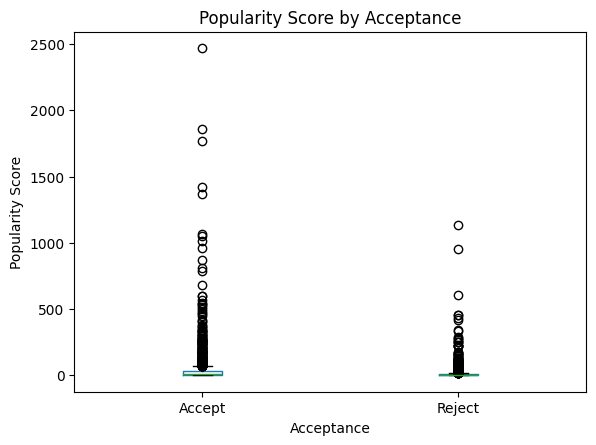

In [16]:
# check is there any corr between decision and citation count

df['decision_numeric'] = df['decision'].apply(lambda x: 1 if x == 'Accept' else 0)

print(df['decision_numeric'].corr(df['citation_count']))

plt.figure(figsize=(6,4))
df.boxplot(column='citation_count', by='decision', grid=False)
plt.title("Popularity Score by Acceptance")
plt.suptitle("")  # remove default title
plt.xlabel("Acceptance")
plt.ylabel("Popularity Score")
plt.show()


/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_5230/2678650564.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/k_/hhv3kf8s74l_gtgs27j_05gw0000gn/T/ipykernel_5230/2678650564.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


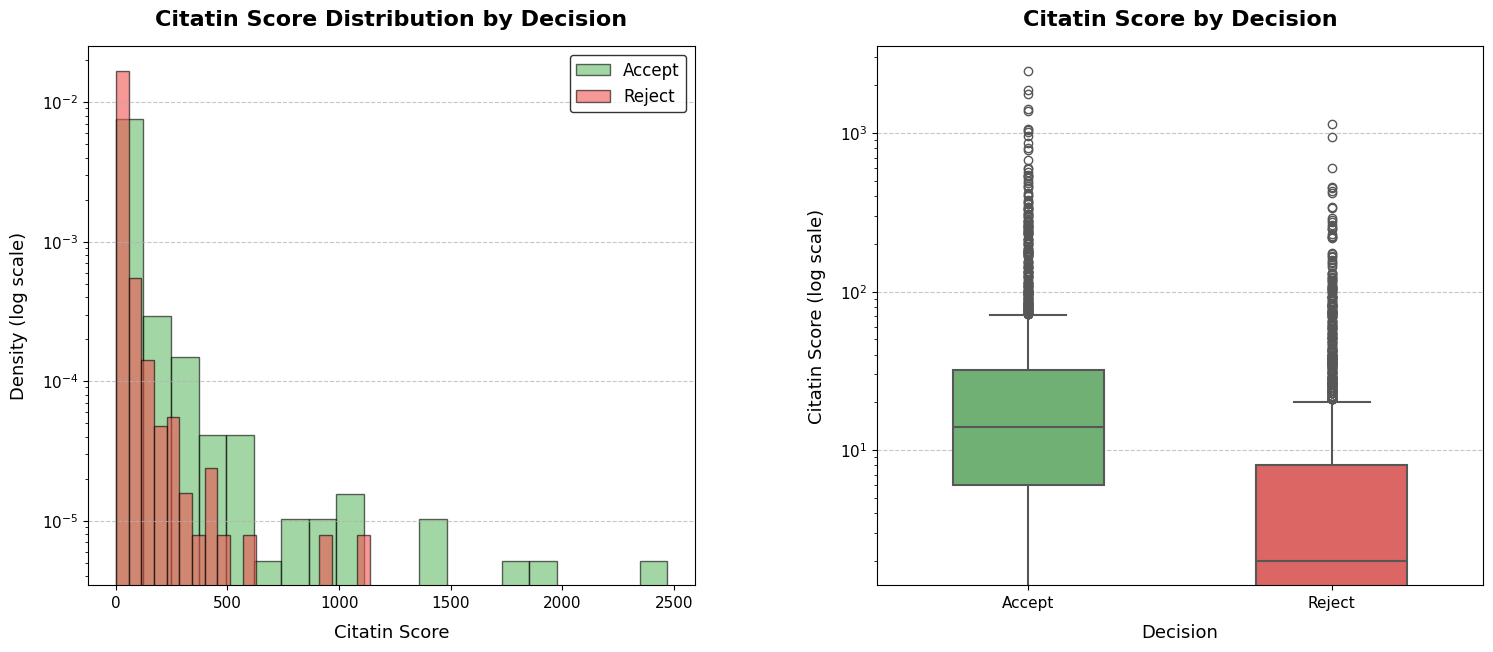

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `df` is your dataframe
accept_scores = df[df["decision"] == "Accept"]["citation_count"]
reject_scores = df[df["decision"] == "Reject"]["citation_count"]

# Define a custom color palette
colors = {"Accept": "#66BB6A", "Reject": "#EF5350"}  # Slightly softer green and red

# Create a figure for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(18, 7), gridspec_kw={'wspace': 0.3})

# Plot 1: Normalized Overlapping Histograms
bins = 20
axes[0].hist(
    accept_scores, bins=bins, alpha=0.6, label="Accept", color=colors["Accept"], edgecolor="black", density=True, 
)
axes[0].hist(
    reject_scores, bins=bins, alpha=0.6, label="Reject", color=colors["Reject"], edgecolor="black", density=True
)

axes[0].set_yscale('log') 
axes[0].set_title("Citatin Score Distribution by Decision", fontsize=16, fontweight="bold", pad=15)
axes[0].set_xlabel("Citatin Score", fontsize=13, labelpad=10)
axes[0].set_ylabel("Density (log scale)", fontsize=13, labelpad=10)
axes[0].tick_params(axis="both", which="major", labelsize=11)
axes[0].legend(fontsize=12, loc="upper right", frameon=True, facecolor="white", edgecolor="black")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)  # Add gridlines for better readability

# Plot 2: Box Plot with Annotations
sns.boxplot(
    data=df, 
    x="decision", 
    y="citation_count", 
    palette=colors, 
    ax=axes[1], 
    width=0.5, 
    linewidth=1.5,

)

# Add median and IQR annotations to the box plot
for i, box in enumerate(axes[1].artists):
    y_values = df[df["decision"] == box.get_label()]["citation_count"]
    median = y_values.median()
    q1, q3 = y_values.quantile([0.25, 0.75])
    axes[1].text(
        i, median, f"Median: {median:.1f}", ha="center", va="center", fontsize=10, color="black", weight="bold"
    )
    axes[1].text(
        i, q1, f"Q1: {q1:.1f}", ha="center", va="center", fontsize=10, color="black", alpha=0.7
    )
    axes[1].text(
        i, q3, f"Q3: {q3:.1f}", ha="center", va="center", fontsize=10, color="black", alpha=0.7
    )
axes[1].set_yscale('log')
axes[1].set_title("Citatin Score by Decision", fontsize=16, fontweight="bold", pad=15)
axes[1].set_xlabel("Decision", fontsize=13, labelpad=10)
axes[1].set_ylabel("Citatin Score (log scale)", fontsize=13, labelpad=10)
axes[1].tick_params(axis="both", which="major", labelsize=11)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)  # Add gridlines for better readability

# Improve spacing and layout
plt.tight_layout()
plt.show()


In [18]:
df["acceptance_num"] = df["decision"].map({"Accept": 1, "Reject": 0})

In [19]:

from scipy.stats import ttest_ind

accept_scores = df[df["decision"] == "Accept"]["citation_count"]
reject_scores = df[df["decision"] == "Reject"]["citation_count"]

t_stat, p_value = ttest_ind(accept_scores, reject_scores, equal_var=False)  # Welch's t-test
print("t-statistic:", t_stat, "p-value:", p_value)


t-statistic: 9.064360484454625 p-value: 3.117536683785088e-19


In [20]:
from scipy.stats import mannwhitneyu

accepted_scores = df.loc[df["acceptance_num"] == 1, "citation_count"]
rejected_scores = df.loc[df["acceptance_num"] == 0, "citation_count"]

u_stat, p_value = mannwhitneyu(accepted_scores, rejected_scores, alternative='two-sided')
print("U-statistic:", u_stat, "p-value:", p_value)


U-statistic: 2694023.5 p-value: 7.934654333419934e-180


In [21]:
import statsmodels.api as sm

X = df["citation_count"]
y = df["acceptance_num"]

X_with_intercept = sm.add_constant(X)  # add intercept
model = sm.Logit(y, X_with_intercept).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.652911
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         acceptance_num   No. Observations:                 3796
Model:                          Logit   Df Residuals:                     3794
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Feb 2025   Pseudo R-squ.:                 0.03759
Time:                        22:00:46   Log-Likelihood:                -2478.5
converged:                       True   LL-Null:                       -2575.3
Covariance Type:            nonrobust   LLR p-value:                 5.159e-44
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.5625      0.038    -14.839      0.000      -0.637      -0.488
citation_count   

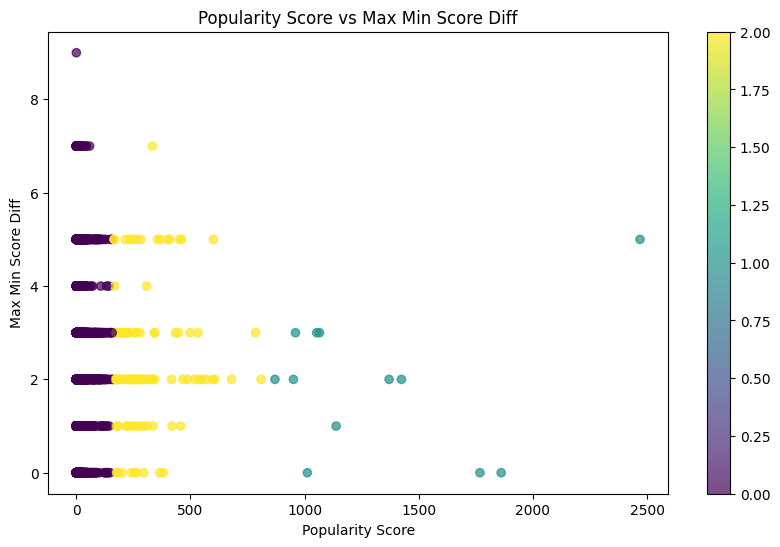

In [22]:
# cluster the papers according to their popularity score df['popularity_score']
from sklearn.cluster import KMeans

X = df[['citation_count']]


# Unpopular papers (0), Moderately Popular papers (1), Popular papers (2)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df['popularity_cluster'] = kmeans.labels_

df['popularity_cluster'].value_counts()


# check the max_min_score_diff for each cluster and see if there is a difference between the clusters plot and also write the max pop score and min pop score for each cluster
plt.figure(figsize=(10,6))
plt.scatter(df['citation_count'], df['max_min_score_diff'], c=df['popularity_cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('Popularity Score')
plt.ylabel('Max Min Score Diff')
plt.title('Popularity Score vs Max Min Score Diff')
plt.colorbar()
plt.show()





In [23]:
quantiles = df['citation_count'].quantile([0, 1/3, 2/3, 1]).values
quantiles.astype(int)

array([   0,    2,   12, 2469])

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create quantile-based categories
def create_citation_categories(df):
    # Calculate tertile thresholds (3 equal groups)
    quantiles = df['citation_count'].quantile([0, 1/3, 2/3, 1]).values
    
    # Create category labels
    df['citation_category'] = pd.cut(df['citation_count'],
                                      bins=quantiles,
                                      labels=['Low', 'Moderate', 'High'],
                                      include_lowest=True)
    return df

# Example usage:
# df = create_citation_categories(your_dataframe)

# Visualization code (updated):
def plot_citation_distributions(df):
    # Define colors
    colors = {'Low': '#4CAF50', 'Moderate': '#FF7043', 'High': '#42A5F5'}
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Citation Count Distribution
    for category in ['Low', 'Moderate', 'High']:
        subset = df[df['citation_category'] == category]['citation_count']
        ax[0].hist(subset, bins=20, alpha=0.7, color=colors[category],
                   edgecolor='black', linewidth=0.8, label=category)
    
    ax[0].set_yscale('log')
    ax[0].set_title('Citation Distribution by Category')
    ax[0].set_xlabel('Citation Count')
    ax[0].set_ylabel('Frequency (log scale)')
    
    # Plot 2: Score Difference Distribution
    for category in ['Low', 'Moderate', 'High']:
        subset = df[df['citation_category'] == category]['max_min_score_diff']
        ax[1].hist(subset, bins=20, alpha=0.7, color=colors[category],
                   edgecolor='black', linewidth=0.8, label=category)
    
    ax[1].set_yscale('log')
    ax[1].set_title('Score Difference Distribution')
    
    plt.tight_layout()
    plt.show()

# Execute with your dataframe:
# plot_citation_distributions(df)


In [25]:
from scipy.stats import f_oneway, kruskal

# Split max_min_score_diff by cluster
cluster_groups = [df[df['popularity_cluster'] == c]['max_min_score_diff'] 
                  for c in sorted(df['popularity_cluster'].unique())]


# 2. Kruskal-Wallis test (non-parametric)
h_stat, p_kw = kruskal(*cluster_groups)
print("Kruskal-Wallis: H-stat =", h_stat, "p-value =", p_kw)


Kruskal-Wallis: H-stat = 1.570085776542731 p-value = 0.4561001400195823


In [26]:
from collections import Counter
# Find the popularity score of the most popular and least popular papers in each cluster
# =================================
# 2. Clean and Normalize Keywords
# =================================
def split_and_normalize(kw_string):
    if pd.isna(kw_string):
        return []
    tokens = kw_string.split(";")
    
    tokens = [t.split(' ') for t in tokens]
    tokens = [item for sublist in tokens for item in sublist if item != '' and \
                                                                            item.strip().lower() != 'learning' \
                                                                            and item.strip().lower() != 'deep' \
                                                                            and item.strip().lower() != 'neural' \
                                                                            and item.strip().lower() != 'networks' \
                                                                            and item.strip().lower() != 'network' \
                                                                            and item.strip().lower() != 'model' \
                                                                            and item.strip().lower() != 'models' \
                                                                            and item.strip().lower() != 'data' \
                                                                            and item.strip().lower() != 'machine' \
                                                                            and item.strip().lower() != 'generation' \
                                                                            and item.strip().lower() != 'vision' \
                                                                            ]
    return [t.strip().lower() for t in tokens if t.strip()]


# extract the raw that are keywords are nan
df.dropna(subset=['keywords'], inplace=True)


df["keyword_list"] = df["keywords"].apply(split_and_normalize)


# =================================
# 3. Compute Global Keyword Frequencies
# =================================
all_keywords = []

for kw_list in df["keyword_list"]:
    all_keywords.extend(kw_list)
freq_counter = Counter(all_keywords)

# Optional: see the frequencies
freq_df = pd.DataFrame(freq_counter.items(), columns=["keyword", "global_freq"])
freq_df.sort_values("global_freq", ascending=False, inplace=True)
print("Global Keyword Frequencies:\n", freq_df)

# =================================
# 4. Popularity Score for Each Paper
# =================================
def compute_popularity_score(kw_list):
    return sum(freq_counter[k] for k in kw_list)

df["popularity_score"] = df["keyword_list"].apply(compute_popularity_score)


Global Keyword Frequencies:
                 keyword  global_freq
0         reinforcement          455
56                graph          331
34       representation          283
37         optimization          256
102            language          235
...                 ...          ...
2171  parameterizations            1
2170     instance-based            1
2169          monophily            1
2168             scaled            1
3508                bev            1

[3509 rows x 2 columns]


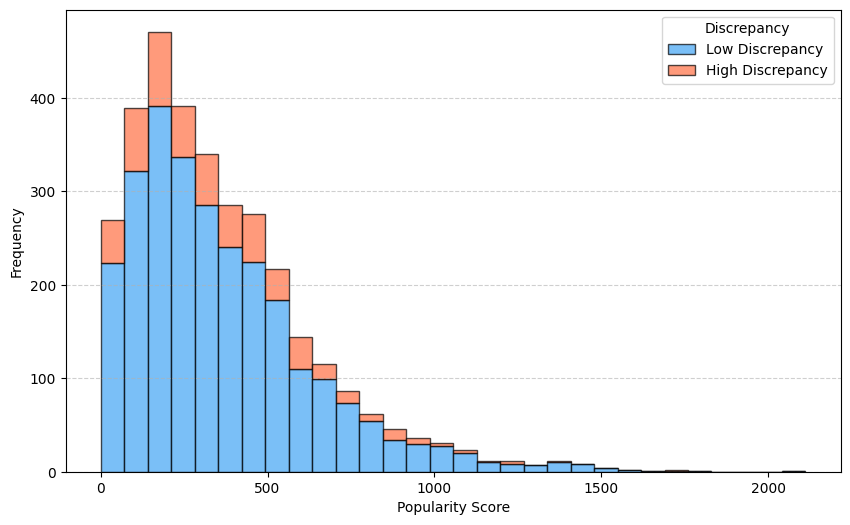

In [27]:
import matplotlib.pyplot as plt

# Provided color palette
cluster_colors = {2: "#4CAF50", 0: "#FF7043", 1: "#42A5F5"}  # Green, Orange, Blue

plt.figure(figsize=(10, 6))

high_discrepancy_paper = df[df['max_min_score_diff'] >= 4]
low_discrepancy_paper = df[df['max_min_score_diff'] < 4]

# Create a stacked histogram so both distributions align on the same bin edges
plt.hist(
    [low_discrepancy_paper['popularity_score'], high_discrepancy_paper['popularity_score']],
    bins=30,
    stacked=True,
    color=[cluster_colors[1], cluster_colors[0]],
    edgecolor='black',
    linewidth=1,
    alpha=0.7,
    label=['Low Discrepancy', 'High Discrepancy']
)

plt.xlabel("Popularity Score")
plt.ylabel("Frequency")
plt.legend(title="Discrepancy")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


0       False
1       False
2       False
3       False
4       False
        ...  
3790    False
3791    False
3793    False
3794    False
3795    False
Name: citation_count, Length: 3243, dtype: bool

In [33]:
(df["citation_count"] < 20).sum()

np.int64(2459)

In [31]:
np.logical_and( df["citation_count"]  > 20, df["citation_count"] < 50 ).sum()

np.int64(428)

In [ ]:
(df["citation_count"] > 50).sum()

np.int64(319)

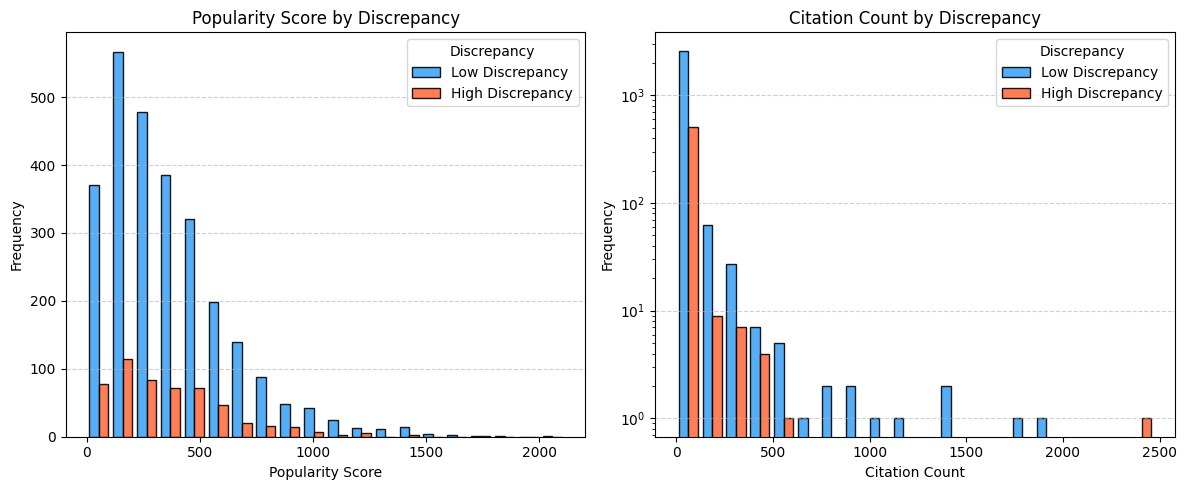

In [28]:
import matplotlib.pyplot as plt

# Provided color palette
cluster_colors = {2: "#4CAF50", 0: "#FF7043", 1: "#42A5F5"}  # Green, Orange, Blue

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

high_discrepancy_paper = df[df['max_min_score_diff'] >= 4]
low_discrepancy_paper = df[df['max_min_score_diff'] < 4]

# First subplot for Popularity Score
axes[0].hist(
    [low_discrepancy_paper['popularity_score'], high_discrepancy_paper['popularity_score']],
    bins=20,
    color=[cluster_colors[1], cluster_colors[0]],
    edgecolor='black',
    linewidth=1,
    alpha=0.9,
    label=[
        'Low Discrepancy', 
        'High Discrepancy'
    ]
)

axes[0].set_title("Popularity Score by Discrepancy")
axes[0].set_xlabel("Popularity Score")
axes[0].set_ylabel("Frequency")
axes[0].legend(title="Discrepancy")
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# Second subplot for Citation Count
axes[1].hist(
    [low_discrepancy_paper['citation_count'], high_discrepancy_paper['citation_count']],
    bins=20,
    color=[cluster_colors[1], cluster_colors[0]],
    edgecolor='black',
    linewidth=1,
    alpha=0.9,
    label=[
        'Low Discrepancy', 
        'High Discrepancy'
    ]
)
axes[1].set_title("Citation Count by Discrepancy")
axes[1].set_yscale('log')
axes[1].set_xlabel("Citation Count")
axes[1].set_ylabel("Frequency")
axes[1].legend(title="Discrepancy")
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()


# plt.savefig('discrepancy_popularity_citation.svg', format='svg')

In [29]:
# check the distrubition difference between the high and low discrepancy papers
from scipy.stats import mannwhitneyu

low_discrepancy_popularity = low_discrepancy_paper['popularity_score']
high_discrepancy_popularity = high_discrepancy_paper['popularity_score']

u_stat, p_value = mannwhitneyu(low_discrepancy_popularity, high_discrepancy_popularity, alternative='two-sided')
print("U-statistic:", u_stat, "p-value:", p_value)


U-statistic: 724172.5 p-value: 0.9211096120041682


In [30]:
from scipy.stats import mannwhitneyu

low_discrepancy_citation = low_discrepancy_paper['citation_count']
high_discrepancy_citation = high_discrepancy_paper['citation_count']

u_stat, p_value = mannwhitneyu(low_discrepancy_citation, high_discrepancy_citation, alternative='two-sided')
print("U-statistic:", u_stat, "p-value:", p_value)

U-statistic: 740606.5 p-value: 0.3492717716962396


In [31]:
# Convert reviewer confidence to numeric, handling NaN values explicitly
df['reviewer1_confidence_numeric'] = df['reviewer1_confidence'].apply(
    lambda x: int(x.split(':')[0].strip()) if pd.notnull(x) else 0
)
df['reviewer2_confidence_numeric'] = df['reviewer2_confidence'].apply(
    lambda x: int(x.split(':')[0].strip()) if pd.notnull(x) else 0
)
df['reviewer3_confidence_numeric'] = df['reviewer3_confidence'].apply(
    lambda x: int(x.split(':')[0].strip()) if pd.notnull(x) else 0
)
df['reviewer4_confidence_numeric'] = df['reviewer4_confidence'].apply(
    lambda x: int(x.split(':')[0].strip()) if pd.notnull(x) else 0
)

# Define a function to calculate the average confidence
def calculate_avg_confidence(row):
    confidences = [
        row['reviewer1_confidence_numeric'],
        row['reviewer2_confidence_numeric'],
        row['reviewer3_confidence_numeric'],
        row['reviewer4_confidence_numeric']
    ]
    # Filter out zeros (representing missing values)
    valid_confidences = [c for c in confidences if c > 0]
    # Calculate average; if no valid values, return 0
    return sum(valid_confidences) / len(valid_confidences) if len(valid_confidences) >= 2 else 0

# Apply the function to each row
df['avg_confidence'] = df.apply(calculate_avg_confidence, axis=1)


In [32]:
def calculate_avg_score(row):
    confidences = [
        row['reviewer1_score'],
        row['reviewer2_score'],
        row['reviewer3_score'],
        row['reviewer4_score']
    ]
    # Filter out zeros (representing missing values)
    valid_confidences = [c for c in confidences if c > 0]
    # Calculate average; if no valid values, return 0
    return sum(valid_confidences) / len(valid_confidences) if len(valid_confidences) >= 2 else 0

# Apply the function to each row
df['avg_score'] = df.apply(calculate_avg_score, axis=1)



In [33]:
df['avg_score']

0       6.500000
1       5.666667
2       4.250000
3       8.000000
4       3.750000
          ...   
3790    3.000000
3791    3.666667
3793    6.500000
3794    3.750000
3795    5.666667
Name: avg_score, Length: 3243, dtype: float64

In [34]:
from sklearn.preprocessing import MinMaxScaler

# Specify the metrics we want to plot
metrics_cols = [
    'acceptance_num',
    'avg_score',
    'max_min_score_diff',
    'citation_count',
    'score_variance',
    'avg_confidence',
    'popularity_score'
]

scaler = MinMaxScaler()
cluster_metrics_scaled = df.copy()
cluster_metrics_scaled[metrics_cols] = scaler.fit_transform(
    cluster_metrics_scaled[metrics_cols]
)


In [35]:
freq_df.head()

,keyword,global_freq
0,reinforcement,455
56,graph,331
34,representation,283
37,optimization,256
102,language,235


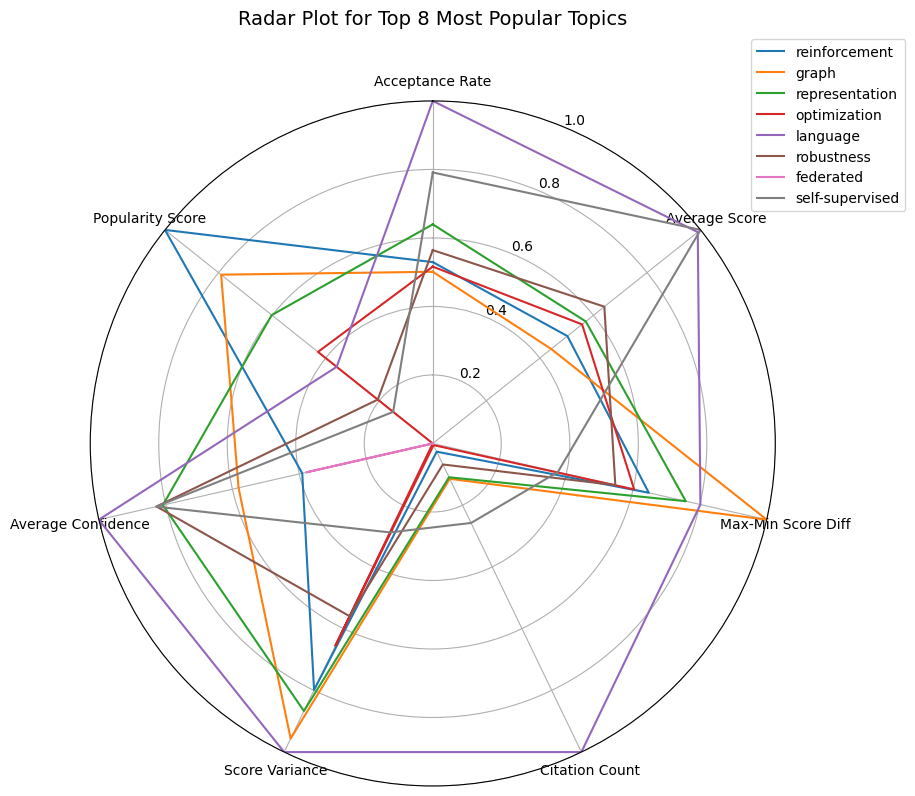

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Top 8 keywords from freq_df
top_keywords = ["reinforcement", "graph", "representation", "optimization", "language", "robustness", "federated", "self-supervised"]

# Prepare data for radar chart
metrics_cols = [
    'acceptance_num',
    'avg_score',
    'max_min_score_diff',
    'citation_count',
    'score_variance',
    'avg_confidence',
    'popularity_score'
]

# Filter and aggregate metrics for each keyword
keyword_metrics = []
for keyword in top_keywords:
    # Filter papers containing the keyword
    keyword_papers = df[df['keyword_list'].apply(lambda kws: keyword in kws)]
    # Aggregate the metrics
    metrics = keyword_papers[metrics_cols].mean().tolist()
    keyword_metrics.append(metrics)

# Normalize the metrics for radar plot using MinMaxScaler
scaler = MinMaxScaler()
keyword_metrics_scaled = scaler.fit_transform(keyword_metrics)

# Define a radar plot function
def radar_factory(num_vars):
    """Return evenly spaced angles for the radar chart."""
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)
    return theta

# Create the radar plot
num_vars = len(metrics_cols)
theta = radar_factory(num_vars)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Plot each keyword's metrics
for i, (keyword, metrics) in enumerate(zip(top_keywords, keyword_metrics_scaled)):
    values = np.concatenate((metrics, [metrics[0]]))  # Close the radar chart
    angles = np.concatenate((theta, [theta[0]]))  # Close the polygon
    ax.plot(angles, values, label=keyword, linewidth=1.5)
    # ax.fill(angles, values, alpha=0.1)

# Add labels and title

metrics_names = [
    'Acceptance Rate',
    'Average Score',
    'Max-Min Score Diff',
    'Citation Count',
    'Score Variance',
    'Average Confidence',
    'Popularity Score'
]
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(theta * 180 / np.pi, metrics_names)
ax.set_ylim(0, 1)
ax.set_title('Radar Plot for Top 8 Most Popular Topics', y=1.1, fontsize=14)

# Add a legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=10)
plt.tight_layout()
# save as an svg
plt.show()


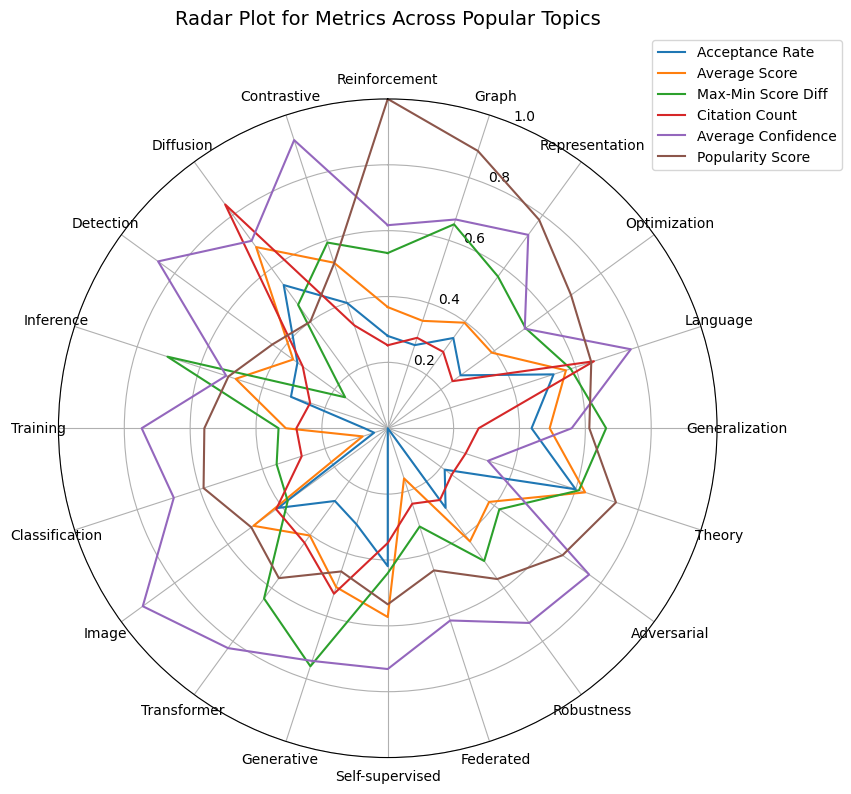

<Figure size 640x480 with 0 Axes>

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Top 8 keywords from freq_df
# top_keywords = ["reinforcement", "graph", "representation", "optimization", "language", "robustness", "federated","adversarial", "self-supervised", "generative"]
top_keywords = freq_df.head(20)['keyword'].tolist()

# Prepare data for radar chart
metrics_cols = [
    'acceptance_num',
    'avg_score',
    'max_min_score_diff',
    'citation_count',
    # 'score_variance',
    'avg_confidence',
    'popularity_score'
]

# Filter and aggregate metrics for each keyword
keyword_metrics = []
for keyword in top_keywords:
    # Filter papers containing the keyword
    keyword_papers = df[df['keyword_list'].apply(lambda kws: keyword in kws)]
    # Aggregate the metrics
    metrics = keyword_papers[metrics_cols].mean().tolist()
    keyword_metrics.append(metrics)

# Normalize the metrics for radar plot using MinMaxScaler
scaler = MinMaxScaler()
keyword_metrics_scaled = scaler.fit_transform(keyword_metrics)

# Define a radar plot function
def radar_factory(num_vars):
    """Return evenly spaced angles for the radar chart."""
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)
    return theta

# Create the radar plot
num_vars = len(top_keywords)
theta = radar_factory(num_vars)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Plot each metric across all keywords

label_metrics_cols = [
    'Acceptance Rate',
    'Average Score',
    'Max-Min Score Diff',
    'Citation Count',
    'Average Confidence',
    'Popularity Score'
]

for i, metric_idx in enumerate(range(len(metrics_cols))):
    values = keyword_metrics_scaled[:, metric_idx]  # Values for each metric across all topics
    values = values * 0.6
    values = np.concatenate((values, [values[0]]))  # Close the radar chart
    angles = np.concatenate((theta, [theta[0]]))  # Close the polygon
    values = values + 0.08 * i  # Separate metrics slightly
    ax.plot(angles, values, label=label_metrics_cols[i], linewidth=1.5)

# Add labels and title

# set top keywords first character to uppercase
top_keywords = [word.capitalize() for word in top_keywords]

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(theta * 180 / np.pi, top_keywords)
ax.set_ylim(0, 1)
ax.set_title('Radar Plot for Metrics Across Popular Topics', y=1.1, fontsize=14)

# Add a legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=10)
plt.tight_layout()
plt.show()
plt.savefig('radar_plot.svg', format='svg')

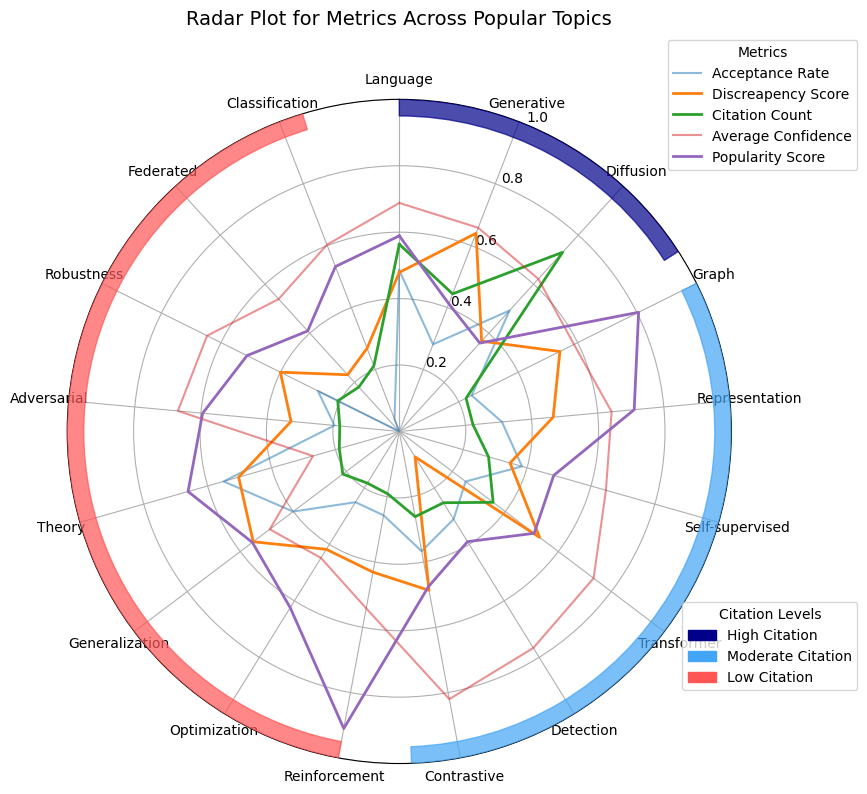

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches

# --- Data Preparation ---

# Assume df and freq_df are already defined in your environment.
# Get the top keywords from freq_df (here we use the top 20)
top_keywords = freq_df.head(20)['keyword'].tolist()
extract_keywords = ['training', 'inference', 'image']
top_keywords = [kw for kw in top_keywords if kw not in extract_keywords]

# Define the metric columns (note: 'citation_count' will be used to group keywords)
metrics_cols = [
    'acceptance_num',
    # 'avg_score',
    'max_min_score_diff',
    'citation_count',   # used for grouping by citation level
    'avg_confidence',
    'popularity_score'
]

# Create a list of tuples: (keyword, aggregated metrics, citation label)
data_list = []
for keyword in top_keywords:
    # Filter papers that mention the keyword
    keyword_papers = df[df['keyword_list'].apply(lambda kws: keyword in kws)]
    # Compute average metrics for this keyword
    metrics = keyword_papers[metrics_cols].mean().tolist()
    citation = metrics[2] if metrics[2] is not None else 0
    # Define citation levels using your thresholds:
    if citation > 50:
        citation_label = "High Citation"
    elif citation > 20:
        citation_label = "Moderate Citation"
    else:
        citation_label = "Low Citation"
    data_list.append((keyword, metrics, citation_label))

# To have the same citation levels together in the radar chart,
# sort the data_list by citation level.
# (Here we define an ordering: High → Moderate → Low)
citation_order = {"High Citation": 0, "Moderate Citation": 1, "Low Citation": 2}
data_list.sort(key=lambda x: citation_order[x[2]])

# Unpack the sorted data
sorted_keywords, sorted_metrics, sorted_citation_labels = zip(*data_list)
sorted_metrics = np.array(sorted_metrics)

# Normalize the aggregated metrics for plotting (each metric is scaled independently)
scaler = MinMaxScaler()
sorted_metrics_scaled = scaler.fit_transform(sorted_metrics)

# --- Create Radar Chart ---

# Each keyword corresponds to one “axis” on the radar chart.
num_vars = len(sorted_keywords)
theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)
# Each sector has angular width equal to:
width = 2 * np.pi / num_vars

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Define labels for the metrics lines
label_metrics_cols = [
    'Acceptance Rate', # low opacity
    # 'Average Score', # çıkar 
    'Discreapency Score', # ismini düzelt and bold
    'Citation Count', # bold 
    'Average Confidence', # low opacity
    'Popularity Score' # bold
]

# Plot each metric line (each line shows how that metric varies across keywords)
for i, metric_idx in enumerate(range(len(metrics_cols))):
    values = sorted_metrics_scaled[:, metric_idx]
    # Scale so that the lines don’t reach the full radius
    values = values * 0.55
    # Close the polygon by appending the first value/angle at the end
    values = np.concatenate((values, [values[0]]))
    angles = np.concatenate((theta, [theta[0]]))
    # Offset each metric’s line slightly for clarity
    values = values + 0.09 * i
    ax.plot(angles, values, label=label_metrics_cols[i], linewidth=1.5 if i in [0, 3] else 2, alpha=0.5 if i in [0, 3] else 1)

# Set the keyword labels (capitalize first letters)
sorted_keywords_cap = [word.capitalize() for word in sorted_keywords]
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(theta * 180 / np.pi, sorted_keywords_cap)
ax.set_ylim(0, 1)
ax.set_title('Radar Plot for Metrics Across Popular Topics', y=1.1, fontsize=14)

# --- Group and Draw Colored Outer Borders by Citation Level ---

# First, group consecutive indices having the same citation label.
groups = []
start_idx = 0
for i in range(1, num_vars):
    if sorted_citation_labels[i] != sorted_citation_labels[i - 1]:
        groups.append((start_idx, i - 1))
        start_idx = i
groups.append((start_idx, num_vars - 1))

# Map each citation label to one of the new colors: blue, purple, and pink.
citation_color_map = {
    "High Citation": "#00008B",
    "Moderate Citation": "#42A5F5",
    "Low Citation": "#FF5555"
}

# For each group, draw one colored wedge along the outer circle.
# We use ax.bar (in polar coordinates) to draw a wedge spanning the group.
for group in groups:
    start, end = group
    group_count = end - start + 1
    # Each keyword's wedge would span 'width' radians.
    # The group covers from angle = (start * width) to angle = ((end+1) * width)
    group_angle_start = start * width
    group_angle_width = group_count * width
    color = citation_color_map[sorted_citation_labels[start]]
    # Draw the wedge at the outer ring (from r=0.95 to r=1.0)
    ax.bar(group_angle_start,
           height=0.05,
           width=group_angle_width * 0.9,  # multiply by 0.95 to leave small gaps between groups
           bottom=0.95,
           color=color,
           edgecolor=color,
           alpha=0.7,
           align='edge',
           zorder=3)

# --- Add Legends ---

# Create legend handles for the citation levels (outer ring)
citation_handles = []
for label, color in citation_color_map.items():
    patch = mpatches.Patch(color=color, label=label)
    citation_handles.append(patch)

# Add two legends:
# 1. For the radar metric lines.
legend1 = ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=10, title='Metrics')
# 2. For the citation-level color grouping.
legend2 = ax.legend(handles=citation_handles, loc='lower right', bbox_to_anchor=(1.2, 0.1), fontsize=10, title='Citation Levels')
ax.add_artist(legend1)  # Make sure the first legend remains visible

plt.tight_layout()
plt.savefig('radar_plot.svg', format='svg')
plt.show()


In [107]:
import pandas as pd
import plotly.graph_objects as go

# Example data: Top 8 topics, their average popularity scores, and citation counts
# top_keywords = ["reinforcement", "graph", "representation", "optimization", "language", "robustness", "federated", "self-supervised"]
top_keywords = freq_df.head(20)['keyword'].tolist()
# Aggregate popularity and citation counts for each topic
popularity_scores = []
citation_counts = []

for keyword in top_keywords:
    keyword_papers = df[df['keyword_list'].apply(lambda kws: keyword in kws)]
    popularity_scores.append(keyword_papers['popularity_score'].mean())
    citation_counts.append(keyword_papers['citation_count'].mean())

# Normalize the popularity and citation scores for visualization
popularity_scores = [round(score, 2) for score in popularity_scores]
citation_counts = [round(score, 2) for score in citation_counts]

# Define Sankey node and link data
nodes = top_keywords + ["High Citation", "Moderate Citation", "Low Citation"]

# Categorize topics based on average citation count
citation_labels = []
for citation in citation_counts:
    if citation > 50:  # Example thresholds for categorization
        citation_labels.append("High Citation")
    elif citation > 20:
        citation_labels.append("Moderate Citation")
    else:
        citation_labels.append("Low Citation")

# Sankey Links
sources = []
targets = []
values = []

# Create links from topics to citation categories
for i, topic in enumerate(top_keywords):
    sources.append(nodes.index(topic))
    targets.append(nodes.index(citation_labels[i]))
    values.append(popularity_scores[i])

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color=["#4E79A7", "#F28E2B", "#76B7B2", "#E15759", "#59A14F", "#EDC948", "#B07AA1", "#FF9DA7", "#4CAF50", "#FF7043", "#42A5F5"]
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=["rgba(0, 123, 255, 0.5)" for _ in values]  # Transparent link colors
    )
))

# Add title and display
fig.update_layout(
    title_text="Relationship Between Popularity Score and Citation Count Across Topics",
    font_size=12,
    title_font_size=16
)

fig.show()


In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Suppose keyword_df has columns: [keyword, popularity_score, citation_count]
# with 20 keywords. We'll create ‘pop_rank’ and ‘cit_rank’ as before:

keyword_df = keyword_df.copy()
keyword_df['pop_rank'] = keyword_df['popularity_score'].rank(
    ascending=False, method='first'
).astype(int)
keyword_df['cit_rank'] = keyword_df['citation_count'].rank(
    ascending=False, method='first'
).astype(int)

# A list of distinct colors (Set2, for instance):
color_palette = px.colors.qualitative.Set2
# Or px.colors.qualitative.Plotly / Dark2 / Pastel / etc.

fig = go.Figure()

# Sort your DataFrame so lines don’t overlap quite as randomly 
# (optional: e.g. by popularity rank)
keyword_df = keyword_df.sort_values('pop_rank')

for i, row in keyword_df.iterrows():
    # pick a color by cycling through the palette
    color = color_palette[i % len(color_palette)]
    
    fig.add_trace(go.Scatter(
        x=[0, 1],
        y=[row['pop_rank'], row['cit_rank']],
        mode='lines+markers+text',
        text=[row['keyword'], row['keyword']],
        textposition=['middle left','middle right'],
        textfont=dict(size=10),
        line=dict(color=color, width=2),
        marker=dict(size=7, color=color),
        showlegend=False
    ))

# Format axes: label them and invert y so rank=1 is at the top
fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=["Popularity Rank", "Citation Rank"]
)
fig.update_yaxes(autorange='reversed')

# Lighten or remove the plot background
fig.update_layout(
    title="Comparing Popularity vs Citation Ranks",
    font_size=12,
    title_font_size=16,
    width=1000,    # a bit wider
    height=600,    # and taller
    plot_bgcolor='white',   # white background
    paper_bgcolor='white',
    margin=dict(l=40, r=40, t=80, b=60)  # add some space around
)

fig.show()


In [72]:
source_idx = nodes.index(keyword)

In [ ]:
nodes